In [1]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-09


In [7]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,229986631680,0.995519,36804000000,Technology,2.882,56.189999,44.986347,52.599998,52.340000,53.160000,52.430000,24128600.0
SITC,2533060352,0.844472,1499137000,Real Estate,1.043,13.490000,NaN,13.840000,13.780000,14.030000,14.030000,1920086.0
UAL,22748133376,1.223721,10320000000,Industrials,9.838,90.669998,85.220001,85.459999,86.480003,87.629997,86.980003,2380100.0
TROW,26297821184,1.069091,6579100000,Financial Services,7.945,108.959999,112.439903,107.260002,107.040001,110.250000,108.650002,1338400.0
ISRG,61556834304,1.269715,7265300000,Healthcare,10.129,533.159973,525.359985,503.769989,505.359985,519.409973,515.500000,491700.0


In [8]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [9]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2008-01-02,320.000000,296.904999,312.381012,320.000000,379785.0,320.000000,SITC
1,2008-01-03,334.286011,323.809998,323.809998,334.286011,144585.0,334.286011,SITC
2,2008-01-04,331.333008,322.856995,326.761993,323.761993,13020.0,323.761993,SITC
3,2008-01-07,319.286011,312.381012,312.381012,319.286011,2940.0,319.286011,SITC
4,2008-01-08,318.951996,306.761993,312.856995,318.951996,25725.0,318.951996,SITC


In [30]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=3)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
p = transform_prices(prices, '2019-08-07')
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
returns.head()

(754, 894)


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-09,0.004658,-0.009569,0.006987,-0.014093,0.004060,0.006331,-0.000564,0.025528,0.001333,0.008754,...,0.001964,-0.000561,-0.035752,0.000704,0.010861,0.083290,-0.026925,0.002088,-0.024823,0.002559
2016-08-10,0.001265,-0.001932,-0.011853,0.000901,-0.007444,-0.004943,-0.008125,0.001054,-0.005989,-0.003207,...,-0.005270,-0.006514,-0.022690,0.004923,-0.031332,0.031837,-0.022690,-0.017014,-0.010909,0.017279
2016-08-11,0.013050,0.008712,0.022821,0.000360,-0.000648,0.007828,0.011945,0.005103,0.005356,-0.022129,...,-0.006395,0.017183,-0.000566,-0.002099,0.004499,0.001697,-0.002548,-0.001060,-0.022059,0.005018
2016-08-12,0.000208,-0.023992,-0.001144,-0.004259,0.002316,0.003585,-0.000450,-0.003223,-0.000222,0.008388,...,-0.001197,-0.000222,-0.002833,-0.001052,-0.001236,0.027568,-0.006245,-0.004951,-0.003759,-0.001728
2016-08-15,0.006232,0.034415,0.027205,0.010602,0.012017,0.002976,0.005399,-0.002425,0.002442,-0.005610,...,-0.001049,-0.000222,0.010511,0.008775,0.004407,0.029826,0.011711,0.017413,0.022641,0.007695


In [31]:
p.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-08,45.934498,25.013086,33.340034,167.983307,103.694847,58.617035,84.092987,120.260002,42.403271,46.121826,...,530.651306,60.853207,37.480000,28.420000,130.012711,57.990002,37.139999,27.415400,2.82,49.784641
2016-08-09,46.148449,24.773727,33.572979,165.615952,104.115845,58.988152,84.045563,123.330002,42.459782,46.525558,...,531.693481,60.819050,36.139999,28.440001,131.424789,62.820000,36.139999,27.472630,2.75,49.912048
2016-08-10,46.206810,24.725857,33.175026,165.765137,103.340813,58.696552,83.362732,123.459999,42.205479,46.376362,...,528.891479,60.422886,35.320000,28.580000,127.306992,64.820000,35.320000,27.005217,2.72,50.774456
2016-08-11,46.809799,24.941280,33.932102,165.824844,103.273819,59.156017,84.358513,124.089996,42.431530,45.350098,...,525.509399,61.461136,35.299999,28.520000,127.879730,64.930000,35.230000,26.976599,2.66,51.029251
2016-08-12,46.819530,24.342882,33.893276,165.118591,103.513039,59.368092,84.320587,123.690002,42.422108,45.730511,...,524.880188,61.447468,35.200001,28.490000,127.721725,66.720001,35.009998,26.843048,2.65,50.941059


In [32]:
def create_momentum_factor(prices, data):

    # demean by sector
    sector_data = data['sector']
    index_ = sector_data.index.intersection(prices.columns)
    sector_data = sector_data.loc[index_]
    prices = prices.loc[:, index_].copy() # to use only the stocks that are in sector_data
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [33]:
momentum = create_momentum_factor(p, data)
print(momentum.shape)
momentum.head()

(503, 877)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-08,-1.385641,1.014558,-0.296077,0.982976,1.590921,-1.646189,1.061930,0.525043,-0.548730,0.063163,...,0.765853,-0.213176,-1.061930,0.596102,1.488281,0.738219,-0.051320,-1.725143,-0.588207,-0.821121
2017-08-09,-1.385641,1.061930,-0.185542,1.026401,1.614607,-1.661980,0.994819,0.631631,-0.603997,-0.071059,...,0.844807,-0.213176,-0.986924,0.501357,1.504072,0.714533,-0.063163,-1.725143,-0.461880,-0.797434
2017-08-10,-1.385641,1.077721,-0.122379,1.022453,1.594869,-1.393536,0.963238,0.769800,-0.576363,-0.126326,...,0.888231,-0.197385,-1.030348,0.426351,1.567235,0.690847,-0.075006,-1.725143,-0.505305,-0.738219
2017-08-11,-1.350112,1.101407,-0.102640,1.065878,1.606712,-1.318530,1.002714,0.821121,-0.698742,-0.059215,...,0.825068,-0.201332,-1.054035,0.422403,1.590921,0.623736,-0.181594,-1.725143,-0.442142,-0.876388
2017-08-14,-1.231681,1.105355,-0.110535,1.164570,1.622503,-1.310635,1.026401,0.880336,-0.734271,0.035529,...,0.813225,-0.094745,-0.979028,0.438194,1.606712,0.193437,-0.209228,-1.725143,-0.453985,-1.523810


In [34]:
def create_smoothed_factor(factor, window=5):
    df = factor.rolling(window).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [35]:
smoothed_momentum = create_smoothed_factor(momentum, 5)
print(smoothed_momentum.shape)
smoothed_momentum.head()

(499, 877)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-14,-1.377745,1.073773,-0.169751,1.057982,1.610659,-1.480386,1.010610,0.730324,-0.635579,-0.035529,...,0.825068,-0.189489,-1.026401,0.481619,1.559339,0.588207,-0.114483,-1.725143,-0.465828,-0.955342
2017-08-15,-1.350112,1.077721,-0.122379,1.105355,1.614607,-1.429066,1.010610,0.596102,-0.639527,-0.019738,...,0.844807,-0.181594,-0.986924,0.450037,1.579078,0.430299,-0.150012,-1.729090,-0.450037,-1.089564
2017-08-16,-1.338269,1.077721,-0.071059,1.172465,1.614607,-1.381693,0.998767,0.453985,-0.682951,-0.023686,...,0.868493,-0.138169,-1.010610,0.461880,1.598816,0.272391,-0.169751,-1.725143,-0.450037,-1.085616
2017-08-17,-1.322478,1.069825,-0.047372,1.227733,1.622503,-1.393536,0.990871,0.307920,-0.714533,0.019738,...,0.963238,-0.138169,-0.994819,0.473723,1.606712,0.094745,-0.201332,-1.725143,-0.457933,-1.093511
2017-08-18,-1.334321,1.046139,-0.059215,1.275105,1.630398,-1.417222,0.986924,0.126326,-0.746114,0.019738,...,1.026401,-0.118431,-0.982976,0.505305,1.614607,-0.031582,-0.217123,-1.725143,-0.473723,-1.073773


In [36]:
f = momentum.loc[smoothed_momentum.index,:].stack()
print(f.shape)
sf = smoothed_momentum.stack()
print(sf.shape)
adj_p = p.loc[smoothed_momentum.index,:].copy()
print(adj_p.shape)

(437623,)
(437623,)
(499, 894)


In [37]:
factor_data = {}
factor_data['factor'] = al.utils.get_clean_factor_and_forward_returns(f, adj_p, periods=[1])
factor_data['smoothed_factor'] = al.utils.get_clean_factor_and_forward_returns(sf, adj_p, periods=[1])

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [38]:
factor_data['factor'].head()

1D    factor  factor_quantile
date       asset                                     
2017-08-14 CSCO   0.007852 -1.231681                1
           UAL    0.003748  1.105355                5
           TROW   0.000716 -0.110535                3
           ISRG   0.021575  1.164570                5
           NVR   -0.002403  1.622503                5

In [39]:
factor_return_list = []
for key, val in factor_data.items():
    factor_return = al.performance.factor_returns(val)
    factor_return.columns = [key]
    factor_return_list.append(factor_return)

In [40]:
factor_return_list[0].head()

,factor
date,
2017-08-14,0.002806
2017-08-15,-0.001505
2017-08-16,-0.002331
2017-08-17,0.001853
2017-08-18,0.000405


factor    1.052335
Name: 2019-08-06 00:00:00, dtype: float64
              factor
date                
2017-08-14  1.002806
2017-08-15  1.001297
2017-08-16  0.998963
2017-08-17  1.000814
2017-08-18  1.001220


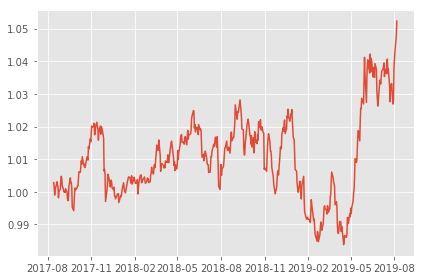

In [48]:
fac_1 = factor_return_list[0]
ret = (fac_1 + 1.0).cumprod() 
print(ret.loc[ret.index[-1],:])
print(ret.head())
plt.plot(ret)
plt.tight_layout()

In [42]:
fra_list = []
for key, val in factor_data.items():
    fra = al.performance.factor_rank_autocorrelation(val).to_frame()
    fra.columns = [key]
    fra_list.append(fra)
    
fra_df = pd.concat(fra_list, axis=1)

In [43]:
fra_df.head()

,factor,smoothed_factor
date,,
2017-08-14,NaN,NaN
2017-08-15,0.996531,0.998666
2017-08-16,0.985311,0.999099
2017-08-17,0.996767,0.999182
2017-08-18,0.996812,0.999263


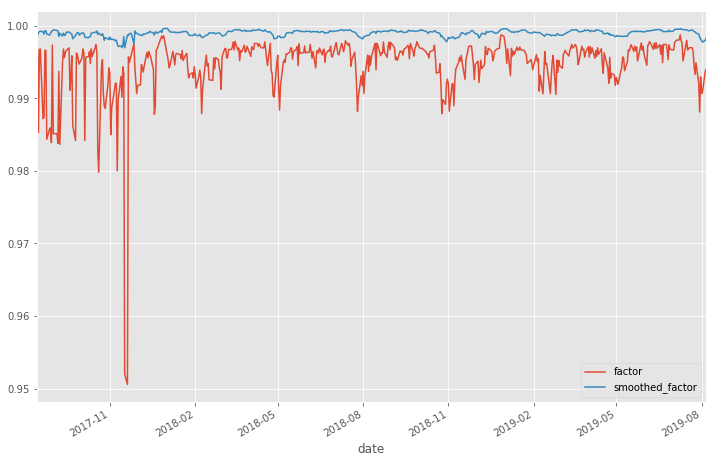

In [44]:
fra_df.plot(figsize=(12,8))

# Quantile Analysis

In [45]:
factor_names = factor_data.keys()
factor_names

dict_keys(['factor', 'smoothed_factor'])

In [46]:
ls_qr = []
for i, factor_name in enumerate(factor_names):
    quantile_return, quantile_stderr = al.performance.mean_return_by_quantile(factor_data[factor_name])
    quantile_return.columns = [factor_name]
    ls_qr.append(quantile_return)
df_ls_qr = pd.concat(ls_qr, axis=1)
df_ls_qr

,factor,smoothed_factor
factor_quantile,,
1,-0.000083,-0.000112
2,-0.000121,-0.000081
3,0.000007,-0.000036
4,0.000022,0.000047
5,0.000175,0.000182


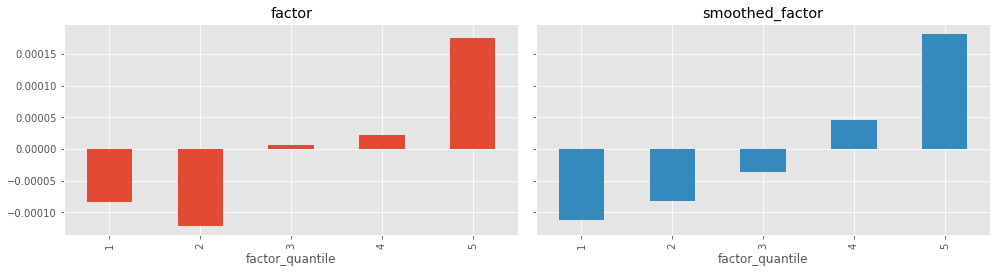

In [47]:
df_ls_qr.plot.bar(subplots=True, sharey=True, layout=(4,2), figsize=(14, 14), legend=False)
plt.tight_layout()

## Convert to basis points

In [58]:
df_ls_qr_bp = 1e4 * df_ls_qr
df_ls_qr_bp

,factor,smoothed_factor
factor_quantile,,
1,-0.832678,-1.121317
2,-1.210075,-0.812493
3,0.071984,-0.357828
4,0.217365,0.466618
5,1.749584,1.822278


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a045550>,
      dtype=object)

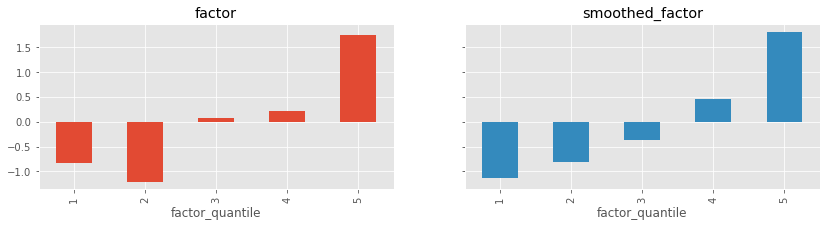

In [63]:
df_ls_qr_bp.plot.bar(subplots=True, sharey=True, layout=(4,2), figsize=(14,14), legend=False)

In [65]:
factor_data['smoothed_factor'].head()

1D    factor  factor_quantile
date       asset                                     
2017-08-14 CSCO   0.007852 -1.377745                1
           UAL    0.003748  1.073773                5
           TROW   0.000716 -0.169751                3
           ISRG   0.021575  1.057982                5
           NVR   -0.002403  1.610659                5

In [68]:
sfpr = al.performance.factor_returns(factor_data['smoothed_factor'])
mean = sfpr.mean()
std = sfpr.std()
sharpe = np.sqrt(252) * mean/std
sharpe

1D    0.671027
dtype: float64

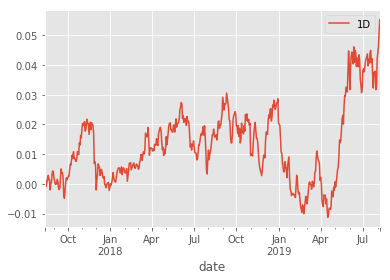

In [70]:
sfpr.cumsum().plot()